In [1]:
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm
from scipy.spatial import distance
from ultralytics import RTDETR
from PIL import Image
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import threading
import random
import torch
import cv2
import os

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [2]:
class CFG:
    dataset_path = "/kaggle/input/byu-locating-bacterial-flagellar-motors-2025/"
    test_image_path = os.path.join(dataset_path, "test")
    model_path = "/kaggle/input/flagellar-motor-detection-2-3-rt-detr-training/byu-locating-bacterial-flagellar-motors/rtdetr-l_fold_0/weights/best.pt"

    seed = 42
    device = 'cuda:0'

In [3]:
torch.manual_seed(CFG.seed)
np.random.seed(CFG.seed)
random.seed(CFG.seed)

In [4]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

gpu_name = torch.cuda.get_device_name(0)
gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1e9  

free_mem = gpu_mem - torch.cuda.memory_allocated(0) / 1e9
BATCH_SIZE = max(8, min(32, int(free_mem * 4)))

torch.cuda.empty_cache()

In [5]:
class GPUProfiler:
    def __init__(self, name):
        self.name = name
        
    def __enter__(self):
        torch.cuda.synchronize()
        return self
        
    def __exit__(self, *args):
        torch.cuda.synchronize()

In [6]:
def normalize_slice(slice_data):
    p2 = np.percentile(slice_data, 2)
    p98 = np.percentile(slice_data, 98)
    clipped_data = np.clip(slice_data, p2, p98)
    normalized = 255 * (clipped_data - p2) / (p98 - p2)
    return np.uint8(normalized)


def preload_image_batch(file_paths):
    images = []
    for path in file_paths:
        img = cv2.imread(path)
        if img is None:
            img = np.array(Image.open(path))
        images.append(img)
    return images


def process_tomogram(tomo_id, model, concentration=1):
    tomo_dir = os.path.join(CFG.test_image_path, tomo_id)
    slice_files = sorted([f for f in os.listdir(tomo_dir) if f.endswith('.jpg')])
    selected_indices = np.linspace(0, len(slice_files)-1, int(len(slice_files) * concentration))
    selected_indices = np.round(selected_indices).astype(int)
    slice_files = [slice_files[i] for i in selected_indices]

    all_detections = []
    streams = [torch.cuda.Stream() for _ in range(min(4, BATCH_SIZE))]
    next_batch_thread = None
    
    for batch_start in tqdm(range(0, len(slice_files), BATCH_SIZE), tomo_id):
        if next_batch_thread is not None:
            next_batch_thread.join()

        batch_end = min(batch_start + BATCH_SIZE, len(slice_files))
        batch_files = slice_files[batch_start:batch_end]

        next_batch_start = batch_end
        next_batch_end = min(next_batch_start + BATCH_SIZE, len(slice_files))
        next_batch_files = slice_files[next_batch_start:next_batch_end] if next_batch_start < len(slice_files) else []

        if next_batch_files:
            next_batch_paths = [os.path.join(tomo_dir, f) for f in next_batch_files]
            next_batch_thread = threading.Thread(target=preload_image_batch, args=(next_batch_paths,))
            next_batch_thread.start()
        else:
            next_batch_thread = None

        sub_batches = np.array_split(batch_files, len(streams))
        for i, sub_batch in enumerate(sub_batches):
            if len(sub_batch) == 0:
                continue
            
            stream = streams[i % len(streams)]
            with torch.cuda.stream(stream):
                sub_batch_paths = [os.path.join(tomo_dir, slice_file) for slice_file in sub_batch]
                sub_batch_slice_nums = [int(slice_file.split('_')[1].split('.')[0]) for slice_file in sub_batch]
                
                with GPUProfiler(f"Inference batch {i+1}/{len(sub_batches)}"):
                    sub_results = model(sub_batch_paths, verbose=False, augment=False)
                    
                for j, result in enumerate(sub_results):
                    if len(result.boxes) > 0:
                        boxes = result.boxes
                        for box_idx, confidence in enumerate(boxes.conf):
                            x1, y1, x2, y2 = boxes.xyxy[box_idx].cpu().numpy()
                            
                            x_center = (x1 + x2) / 2
                            y_center = (y1 + y2) / 2

                            all_detections.append({
                                'z': round(sub_batch_slice_nums[j]),
                                'y': round(y_center),
                                'x': round(x_center),
                                'confidence': float(confidence),
                                'tomo_id': tomo_id
                            })

        torch.cuda.synchronize()

    if next_batch_thread is not None:
        next_batch_thread.join()

    if not all_detections:
        all_detections.append({
            'z': -1,
            'y': -1,
            'x': -1,
            'confidence': -1,
            'tomo_id': tomo_id
        })
        

    return all_detections

In [7]:
model = RTDETR(CFG.model_path)
model.to(CFG.device)
model.fuse()

if torch.cuda.get_device_capability(0)[0] >= 7: 
    model.model.half()

rt-detr-l summary: 302 layers, 31,985,795 parameters, 0 gradients, 103.4 GFLOPs


In [8]:
%%time

test_tomos = sorted([d for d in os.listdir(CFG.test_image_path) if os.path.isdir(os.path.join(CFG.test_image_path, d))])

all_detections = []
with ThreadPoolExecutor(max_workers=1) as executor:
    future_to_tomo = {}
    
    for i, tomo_id in enumerate(test_tomos, 1):
        future = executor.submit(process_tomogram, tomo_id, model)
        future_to_tomo[future] = tomo_id
    
    for future in future_to_tomo:
        tomo_id = future_to_tomo[future]
        try:
            torch.cuda.empty_cache()
            result = future.result()
            all_detections.extend(result)
        except Exception as e:
            print(e)

tomo_003acc:   0%|          | 0/16 [00:00<?, ?it/s]

tomo_00e047:   0%|          | 0/10 [00:00<?, ?it/s]

tomo_01a877:   0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 1min 27s, sys: 7.16 s, total: 1min 34s
Wall time: 1min 18s


In [9]:
all_detections = pd.DataFrame(all_detections)
if all_detections.tomo_id.nunique() == 3:
    all_detections.to_csv("all_detections.csv", index=False)

In [10]:
def postprocess(df, confidence_threshold, group_distance_threshold, min_detection_per_group):
    df = df[df['confidence'] >= confidence_threshold]
    
    df_agg_det_tomo_list = []
    for tomo_id, df_det_tomo in df.groupby('tomo_id'):
        dist_mat = distance.cdist(df_det_tomo[['x', 'y', 'z']], df_det_tomo[['x', 'y', 'z']], metric='euclidean')
        adj_mat = (dist_mat <= group_distance_threshold).astype(int)
        np.fill_diagonal(adj_mat, 0)
        G = nx.from_numpy_array(adj_mat)
        connected_components = list(nx.connected_components(G))
        agg_det_dict_list = []
        for group_idx_set in connected_components:
            df_det_grp = df_det_tomo.iloc[list(group_idx_set)] 

            z = (df_det_grp['z'] * df_det_grp['confidence']).sum() / df_det_grp['confidence'].sum()
            y = (df_det_grp['y'] * df_det_grp['confidence']).sum() / df_det_grp['confidence'].sum()
            x = (df_det_grp['x'] * df_det_grp['confidence']).sum() / df_det_grp['confidence'].sum()
            score_mean = df_det_grp['confidence'].mean()

            agg_det = {
                'tomo_id': tomo_id,
                'x': x,
                'y': y,
                'z': z,
                'confidence': score_mean,
                'group_det_count': len(group_idx_set),
            }
            agg_det_dict_list.append(agg_det)
            
        df_agg_det_tomo = pd.DataFrame(agg_det_dict_list)
        df_agg_det_tomo = df_agg_det_tomo[df_agg_det_tomo['group_det_count'] >= min_detection_per_group]
        df_agg_det_tomo = df_agg_det_tomo.sort_values(by=['group_det_count', 'confidence'], ascending=False).iloc[:1]
        df_agg_det_tomo_list.append(df_agg_det_tomo)
        
    return pd.concat(df_agg_det_tomo_list)

In [11]:
def add_no_motor_tomos(predictions, test_tomos):
    no_motors_ids = list(set(test_tomos) - set(predictions['tomo_id']))
    
    no_motors_sf = pd.DataFrame({
        'tomo_id': no_motors_ids,
        'x': [-1] * len(no_motors_ids),
        'y': [-1] * len(no_motors_ids),
        'z': [-1] * len(no_motors_ids),
        'confidence': [0] * len(no_motors_ids),
        'fold': [-1] * len(no_motors_ids)
    })
    
    return pd.concat([predictions, no_motors_sf])

def fix_dtypes(predictions):
    predictions["x"] = predictions["x"].astype(int)
    predictions["y"] = predictions["y"].astype(int)
    predictions["z"] = predictions["z"].astype(int)
    return predictions

In [12]:
final_predictions = postprocess(all_detections, confidence_threshold=0.6170582213804651, group_distance_threshold=82, min_detection_per_group=3)
final_predictions = add_no_motor_tomos(final_predictions, test_tomos)
final_predictions = fix_dtypes(final_predictions)
final_predictions

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,tomo_id,x,y,z,confidence,group_det_count,fold
1,tomo_00e047,606,542,172,0.873196,35.0,NaN
0,tomo_01a877,253,633,116,0.781553,72.0,NaN
0,tomo_003acc,-1,-1,-1,0.000000,NaN,-1.0


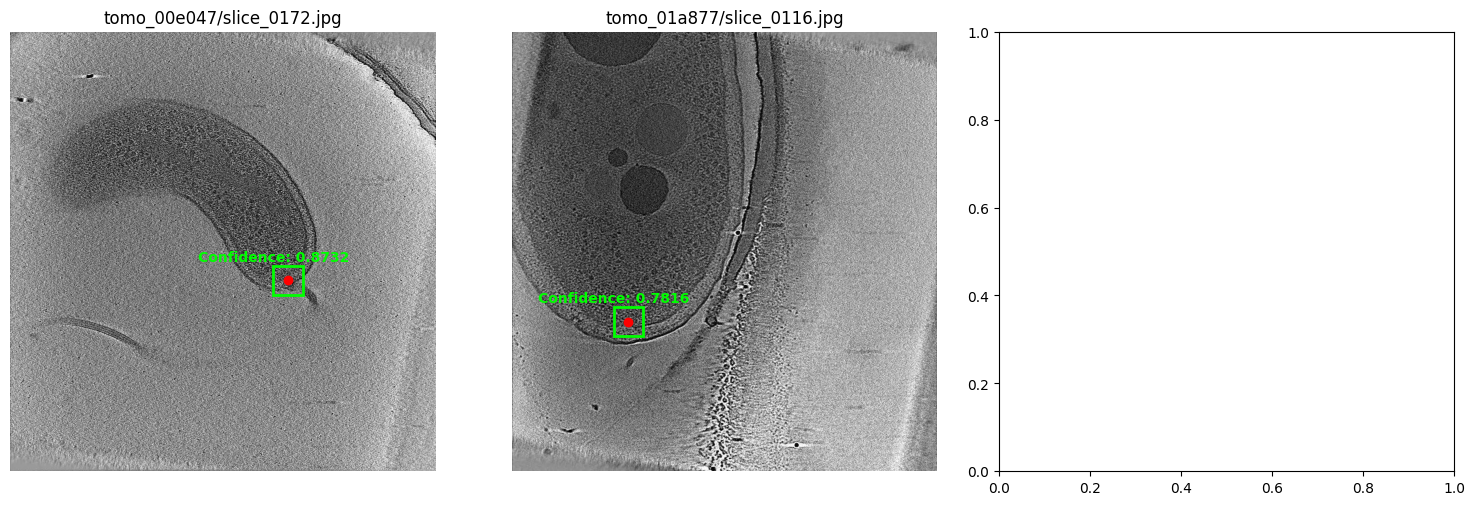

In [13]:
if len(final_predictions) == 3:
    points = []
    image_paths = []
    
    for i, r in final_predictions.iterrows():
        if (
            r['z'] != -1 and 
            r['y'] != -1 and 
            r['x'] != -1
        ):
            slice_num = int(r['z'])
            slice_str = f"{slice_num:04d}"
            image_path = f"/kaggle/input/byu-locating-bacterial-flagellar-motors-2025/test/{r['tomo_id']}/slice_{slice_str}.jpg"
            image_paths.append(image_path)
            points.append((r['x'], r['y'], r['confidence']))

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    box_size = 64
    half_box = box_size // 2

    for i, path in enumerate(image_paths):
        img = cv2.imread(path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img_rgb)
        x, y, confidence = points[i]
        
        axes[i].scatter(x, y, color="red")
        
        rect = patches.Rectangle((x - half_box, y - half_box), box_size, box_size, linewidth=2, edgecolor='lime', facecolor='none')
        axes[i].add_patch(rect)
        
        axes[i].text(x - half_box, y - half_box - 10, f"Confidence: {confidence:.4f}", color='lime', fontsize=10, weight='bold', ha='center')
        axes[i].set_title(path.split("/")[-2] + "/" + path.split("/")[-1])
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [14]:
submission = final_predictions.copy()
submission = submission.rename(columns={"x": "Motor axis 2", "y": "Motor axis 1", "z": "Motor axis 0"})
submission = submission[['tomo_id', 'Motor axis 0', 'Motor axis 1', 'Motor axis 2']]
submission.to_csv("submission.csv", index=False)
submission.head()

,tomo_id,Motor axis 0,Motor axis 1,Motor axis 2
1,tomo_00e047,172,542,606
0,tomo_01a877,116,633,253
0,tomo_003acc,-1,-1,-1
